In [ ]:
# Import needed modules
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter, freqz, bode, filtfilt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [ ]:
# Download the dataset
data_path = 'project_data.csv'
df = pd.read_csv(data_path, header=None, sep=';')
raw_data = df.values

In [ ]:
# The second element contains the signal key
labels = np.array(raw_data[:, 0])
print(f"Shape of the signal keys: {labels.shape}")

# The second element contains the labels
labels = np.array(raw_data[:, 1])
print(f"Shape of the labels: {labels.shape}")

# The other data points are the ECG data
data = np.array(raw_data[:, 2:], dtype=np.float64)
print(f"Shape of the dataset: {data.shape}")

# Count the number of abnormal (0) and normal (1) ECG samples
[ABNORMAL, NORMAL, OTHER], n = np.unique(labels, return_counts=True)
print(f"Number of abnormal rythm samples: {n[0]}")
print(f"Number of normal rythm samples: {n[1]}")
print(f"Number of other rythm samples: {n[2]}")

Shape of the signal keys: (8229,)
Shape of the labels: (8229,)
Shape of the dataset: (8229, 3000)
Number of abnormal rythm samples: 737
Number of normal rythm samples: 5040
Number of other rythm samples: 2452


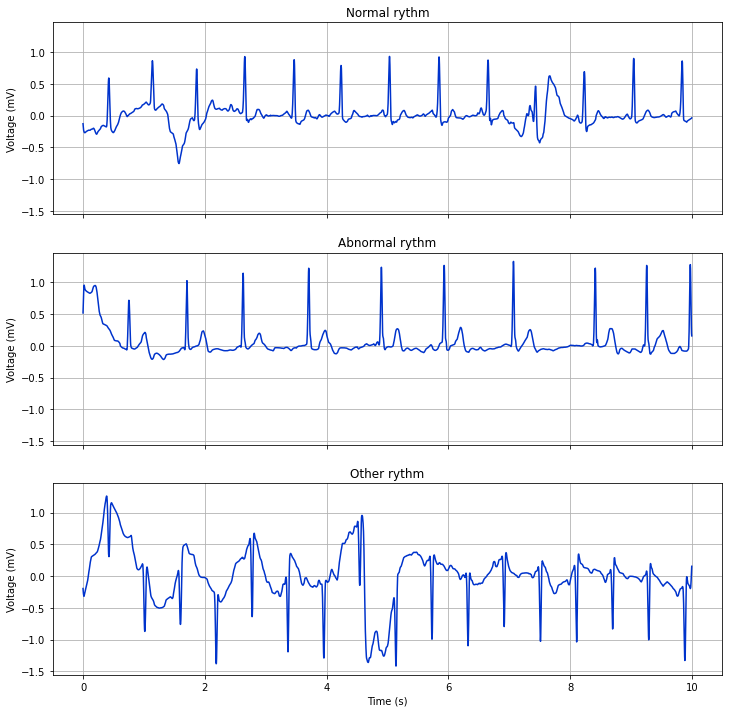

In [ ]:
# Define sampling frequency and interval
f_s = 300
T_s = 1 / f_s

# Define the time vector
t = np.arange(0, data.shape[1]) * T_s

# Visualize some normal and abnormal rythms
normal_data = data[labels == NORMAL]
abnormal_data = data[labels == ABNORMAL]
other_data = data[labels == OTHER]

fig, ax = plt.subplots(3, 1,sharex=True, sharey=True, figsize=(12,12))

ax[0].plot(t, normal_data[0,:], color='#0033cc')
ax[0].set_ylabel('Voltage (mV)')
ax[0].grid(True, which='both', axis='both')
ax[0].set_title("Normal rythm")

ax[1].plot(t, abnormal_data[0,:], color='#0033cc')
ax[1].set_ylabel('Voltage (mV)')
ax[1].grid(True, which='both', axis='both')
ax[1].set_title("Abnormal rythm")

ax[2].plot(t, other_data[20,:], color='#0033cc')
ax[2].set_ylabel('Voltage (mV)')
ax[2].grid(True, which='both', axis='both')
ax[2].set_title("Other rythm")

plt.xlabel('Time (s)')
plt.savefig('examples.pdf', dpi=120, format='pdf', bbox_inches='tight')

In [ ]:
# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.1, random_state=21,
)
print(test_labels.shape)
# Test indecies 0 (Normal), 2 (AF), and -1 (Other)

(823,)


In [ ]:
# Normalize the data between 0 and 1
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_data = train_data[..., tf.newaxis]
test_data = test_data[..., tf.newaxis]

Text(0.5, 0, 'Time (s)')

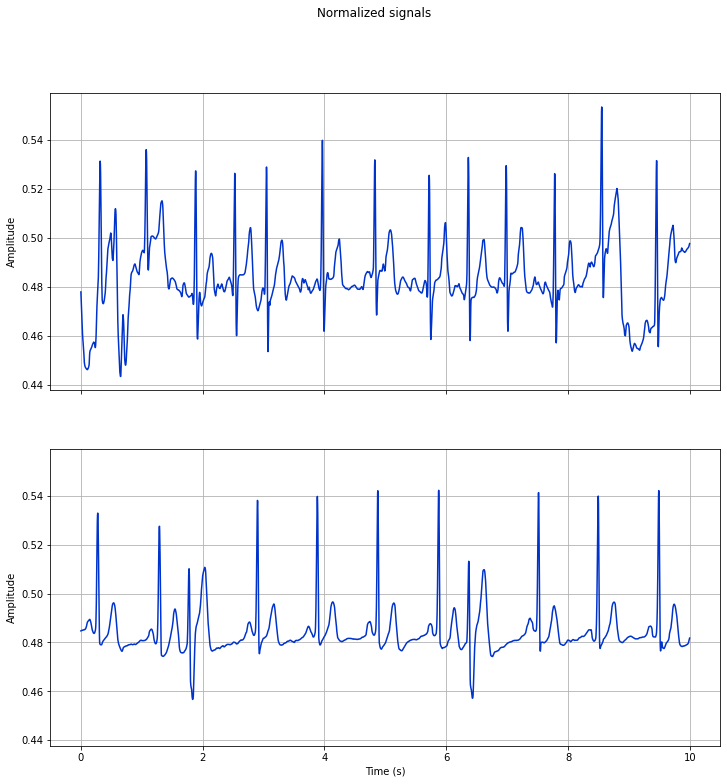

In [ ]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12,12))

ax[0].plot(t, train_data[0,:], color='#0033cc')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True, which='both', axis='both')

ax[1].plot(t, train_data[1,:], color='#0033cc')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True, which='both', axis='both')

plt.suptitle("Normalized signals")
plt.xlabel('Time (s)')

In [ ]:
# Add some noise to the training and test sets
noisy_train_data = np.zeros(shape=train_data.shape)
noisy_test_data = np.zeros(shape=test_data.shape)

def generate_baseline_wander_noise(ecg_signal, t):
  A = np.random.uniform(0, 0.15) * np.abs((np.max(ecg_signal) - np.min(ecg_signal)))  # Amplitude
  w = 2*np.pi*np.random.uniform(0.15, 0.3)  # Angular frequency
  phi = np.random.uniform(-np.pi, np.pi) # Phase
  return A*np.sin(w*t + phi).reshape(ecg_signal.shape[0], 1)

def generate_power_line_interference(ecg_signal, t):
  A = np.random.uniform(0, 0.5) * np.abs((np.max(ecg_signal) - np.min(ecg_signal)))  # Amplitude
  w = 2*np.pi*np.random.uniform(49.8, 50.2)  # Angular frequency
  phi = np.random.uniform(-np.pi, np.pi) # Phase
  return A*np.sin(w*t + phi).reshape(ecg_signal.shape[0], 1)

def generate_muscle_artefacts(ecg_signal, t):
  A = np.random.uniform(0, 0.1) * np.abs((np.max(ecg_signal) - np.min(ecg_signal)))  # Amplitude
  w = 2*np.pi*np.random.uniform(0, 10000)  # Angular frequency
  phi = np.random.uniform(-np.pi, np.pi) # Phase
  return A*np.sin(w*t + phi).reshape(ecg_signal.shape[0], 1)

for i in range(train_data.shape[0]):
  baseline_wander_noise = generate_baseline_wander_noise(train_data[i], t)
  power_line_interference = generate_power_line_interference(train_data[i], t)
  muscle_artefacts = generate_muscle_artefacts(train_data[i], t)
  noisy_train_data[i] = train_data[i] + baseline_wander_noise + power_line_interference + muscle_artefacts

for i in range(test_data.shape[0]):
  baseline_wander_noise = generate_baseline_wander_noise(test_data[i], t)
  power_line_interference = generate_power_line_interference(test_data[i], t)
  muscle_artefacts = generate_muscle_artefacts(test_data[i], t)
  noisy_test_data[i] = test_data[i] + baseline_wander_noise + power_line_interference + muscle_artefacts

noisy_train_data = tf.clip_by_value(noisy_train_data, clip_value_min=0., clip_value_max=1.)
noisy_test_data = tf.clip_by_value(noisy_test_data, clip_value_min=0., clip_value_max=1.)

In [ ]:
# Define a function to compute Fast-Fourier Transform
def FFT(signal):
  signal = np.array(signal).reshape(-1)
  N = signal.shape[0]
  y = signal - np.mean(signal)
  yf = fft(y)
  xf = fftfreq(N, T_s)[:N//2]
  return xf, 2.0/N * np.abs(yf[0:N//2])

In [ ]:
# Define a function to perform filtering
def do_filtering(signal, plot_response=False):
  signal = np.array(signal).reshape(-1)
  u = np.mean(signal)
  y = signal - u
  b1, a1 = butter(3, Wn=45, fs=f_s, btype='lowpass', analog=False)
  b2, a2 = butter(3, Wn=[45, 55], fs=f_s, btype='bandstop', analog=False)
  if plot_response:
    w1, mag1, phase1 = bode((b1, a1))
    w1, h1 = freqz(b1, a1, fs=f_s, worN=8000)

    w2, mag2, phase2 = bode((b2, a2))
    w2, h2 = freqz(b2, a2, fs=f_s, worN=8000)

    plt.plot(w1, np.abs(h1) * np.abs(h2), 'b')

    plt.xlim(0, 0.5*f_s)
    plt.title("Frequency Response")
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    plt.show()

  y1 = filtfilt(b1, a1, y)
  y2 = filtfilt(b2, a2, y1)
  return y2 + u

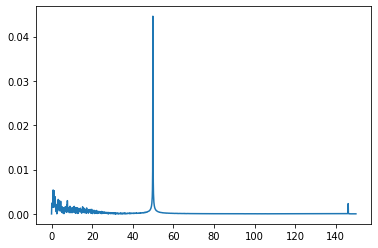

In [ ]:
xf, yf = FFT(noisy_train_data[0,:])
plt.plot(xf, yf)

Text(0.5, 0.98, 'Noisy signals and their Fourier transforms')

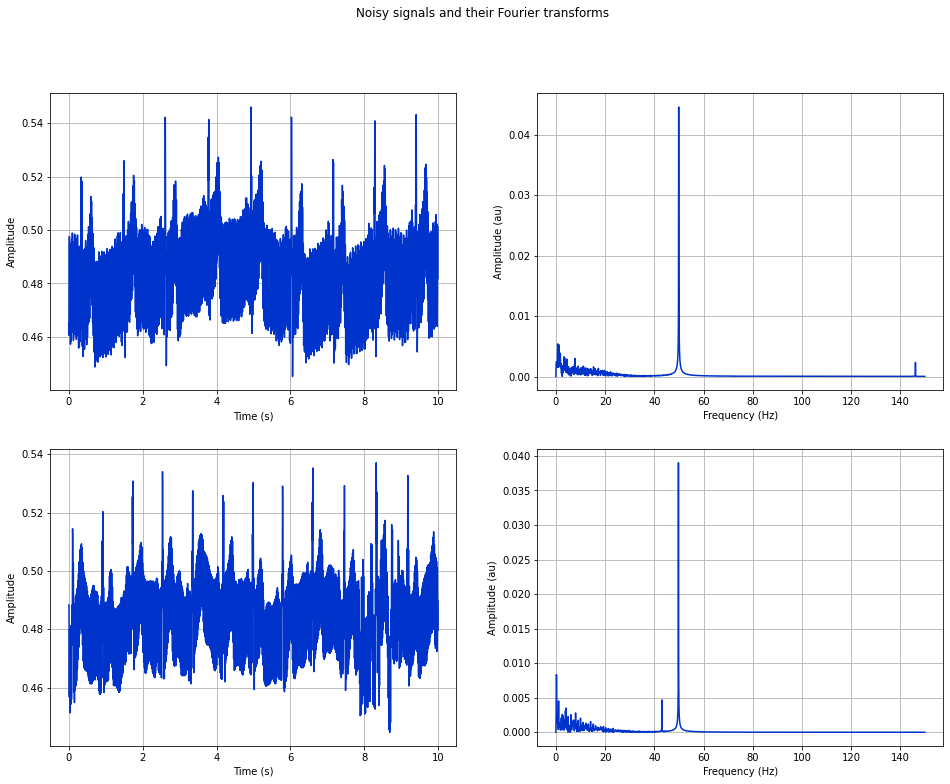

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(16,12))

ax[0][0].plot(t, noisy_test_data[0,:], color='#0033cc')
ax[0][0].set_ylabel('Amplitude')
ax[0][0].grid(True, which='both', axis='both')
ax[0][0].set_xlabel("Time (s)")

ax[0][1].plot(*FFT(noisy_train_data[0,:]), color='#0033cc')
ax[0][1].set_ylabel('Amplitude (au)')
ax[0][1].grid(True, which='both', axis='both')
ax[0][1].set_xlabel("Frequency (Hz)")

ax[1][0].plot(t, noisy_test_data[1,:], color='#0033cc')
ax[1][0].set_ylabel('Amplitude')
ax[1][0].grid(True, which='both', axis='both')
ax[1][0].set_xlabel("Time (s)")

ax[1][1].plot(*FFT(noisy_train_data[1,:]), color='#0033cc')
ax[1][1].set_ylabel('Amplitude (au)')
ax[1][1].grid(True, which='both', axis='both')
ax[1][1].set_xlabel("Frequency (Hz)")

plt.suptitle("Noisy signals and their Fourier transforms")

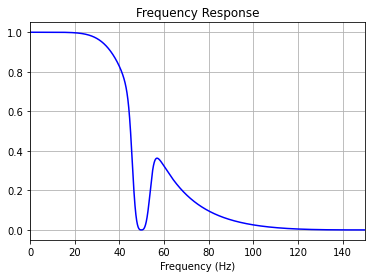

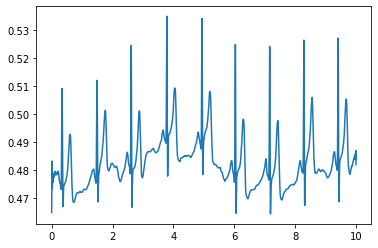

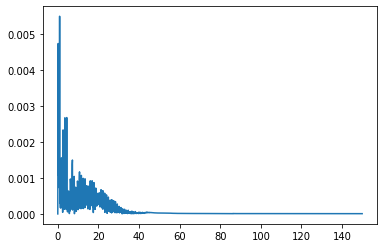

In [ ]:
y = do_filtering(noisy_test_data[0,:], plot_response=True)

plt.plot(t, y)
plt.show()

plt.plot(*FFT(y))
plt.show()

In [ ]:
# Define the denoising autoencoder
class Denoiser(Model):
  def __init__(self):
    super(Denoiser, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(3000, 1)),
      layers.Conv1D(16, 3, activation='relu', padding='same', strides=2),
      layers.Conv1D(8, 3, activation='relu', padding='same', strides=2),
      layers.Conv1D(4, 3, activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv1DTranspose(4, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv1DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv1DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv1D(1, 3, activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
autoencoder = Denoiser()

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = autoencoder.fit(noisy_train_data, train_data, 
          epochs=30, 
          validation_split=0.2,
          shuffle=True,)

Epoch 1/30
186/186 [==============================] - 20s 100ms/step - loss: 3.2762e-04 - val_loss: 3.0635e-04
Epoch 2/30
186/186 [==============================] - 18s 99ms/step - loss: 2.8828e-04 - val_loss: 2.0353e-04
Epoch 3/30
186/186 [==============================] - 20s 110ms/step - loss: 1.3508e-04 - val_loss: 1.1697e-04
Epoch 4/30
186/186 [==============================] - 18s 99ms/step - loss: 1.0006e-04 - val_loss: 9.4711e-05
Epoch 5/30
186/186 [==============================] - 18s 99ms/step - loss: 8.1577e-05 - val_loss: 9.1667e-05
Epoch 6/30
186/186 [==============================] - 22s 117ms/step - loss: 7.5245e-05 - val_loss: 8.3877e-05
Epoch 7/30
186/186 [==============================] - 19s 102ms/step - loss: 7.2229e-05 - val_loss: 8.2462e-05
Epoch 8/30
186/186 [==============================] - 20s 107ms/step - loss: 6.8987e-05 - val_loss: 7.8797e-05
Epoch 9/30
186/186 [==============================] - 18s 99ms/step - loss: 6.8779e-05 - val_loss: 7.6079e-05
Epoch

In [ ]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 1500, 16)          64        
                                                                 
 conv1d_17 (Conv1D)          (None, 750, 8)            392       
                                                                 
 conv1d_18 (Conv1D)          (None, 375, 4)            100       
                                                                 
Total params: 556
Trainable params: 556
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_transpose_12 (Conv1D  (None, 750, 4)           52        
 Transpose)                                                      
                                  

In [ ]:
encoded_ecgs = autoencoder.encoder(noisy_test_data).numpy()
decoded_ecgs = autoencoder.decoder(encoded_ecgs).numpy()

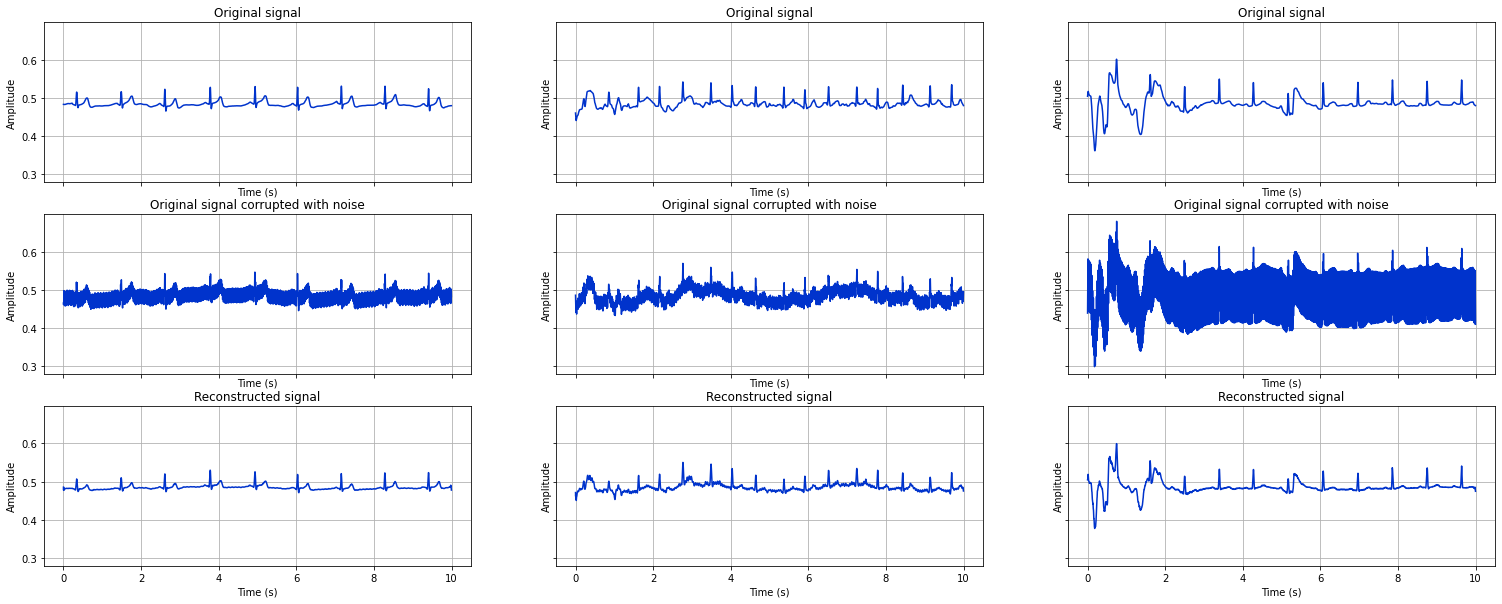

In [ ]:
n = 3
ind = [0, 2, -1]
fig, ax = plt.subplots(3, n, sharex=True, sharey=True, figsize=(26, 10))
for i in range(n):
    ix = ind[i]
    # display original + noise
    ax[0][i].set_title("Original signal")
    ax[0][i].plot(t, tf.squeeze(test_data[ix]), color='#0033cc')
    ax[0][i].grid(True)
    ax[0][i].set_ylabel('Amplitude')
    ax[0][i].set_xlabel('Time (s)')

    # display original + noise
    ax[1][i].set_title("Original signal corrupted with noise")
    ax[1][i].plot(t, tf.squeeze(noisy_test_data[ix]), color='#0033cc')
    ax[1][i].grid(True)
    ax[1][i].set_ylabel('Amplitude')
    ax[1][i].set_xlabel('Time (s)')

    # display reconstruction
    ax[2][i].set_title("Reconstructed signal")
    ax[2][i].plot(t, tf.squeeze(decoded_ecgs[ix]), color='#0033cc')
    ax[2][i].grid(True)
    ax[2][i].set_ylabel('Amplitude')
    ax[2][i].set_xlabel('Time (s)')

#plt.suptitle("Example results of using the designed denoising autoencoder on noisy ECG recordings")
plt.show()
fig.savefig('results.pdf', dpi=120, format='pdf', bbox_inches='tight')

2.3304088709201137e-05
1.658266e-05


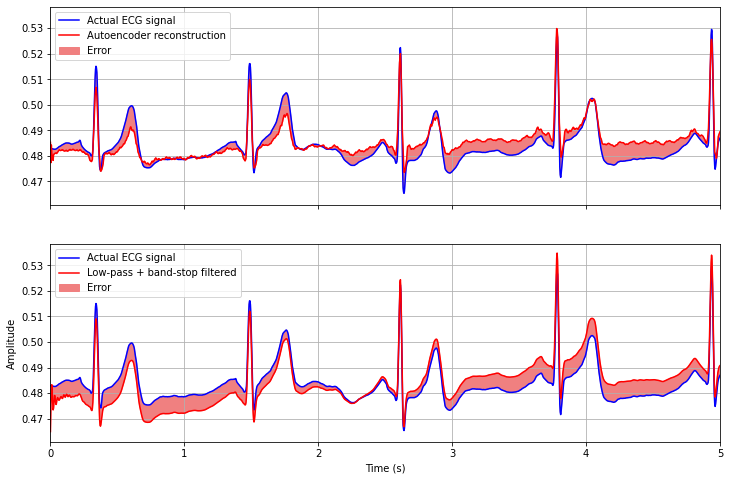

In [ ]:
y = do_filtering(noisy_test_data[0,:])

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 8))

print(mean_squared_error(tf.squeeze(test_data[0]), y))
print(mean_squared_error(tf.squeeze(test_data[0]), tf.squeeze(decoded_ecgs[0])))

ax[0].plot(t, tf.squeeze(test_data[0]), 'b')
ax[0].plot(t, tf.squeeze(decoded_ecgs[0]), 'r')
ax[0].fill_between(t, tf.squeeze(decoded_ecgs[0]),  tf.squeeze(test_data[0]), color='lightcoral')
ax[0].legend(labels=["Actual ECG signal", "Autoencoder reconstruction", "Error"], loc='upper left')
ax[0].grid()
ax[0].set_xlim([0, 5])

ax[1].plot(t, tf.squeeze(test_data[0]), 'b')
ax[1].plot(t, y, 'r')
ax[1].fill_between(t, y,  tf.squeeze(test_data[0]), color='lightcoral')
ax[1].legend(labels=["Actual ECG signal", "Low-pass + band-stop filtered", "Error"], loc='upper left')
ax[1].grid()
ax[1].set_xlim([0, 5])

plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
#plt.xlim([1, 5])
plt.show()
fig.savefig('results2.pdf', dpi=120, format='pdf', bbox_inches='tight')


In [ ]:
n = test_data.shape[0]

RMSE_Autoencoder = []
RMSE_Lowpass = []

for i in range(2):
  decoded = tf.squeeze(decoded_ecgs[i])
  filtered = do_filtering(noisy_test_data[0,:])

  RMSE_Autoencoder.append(np.sqrt(np.mean((test_data[i]-decoded)**2)))
  RMSE_Lowpass.append(np.sqrt(np.mean((test_data[i]-filtered)**2)))

print(np.mean(RMSE_Autoencoder))
print(np.mean(RMSE_Lowpass))

0.010725546
0.012756948


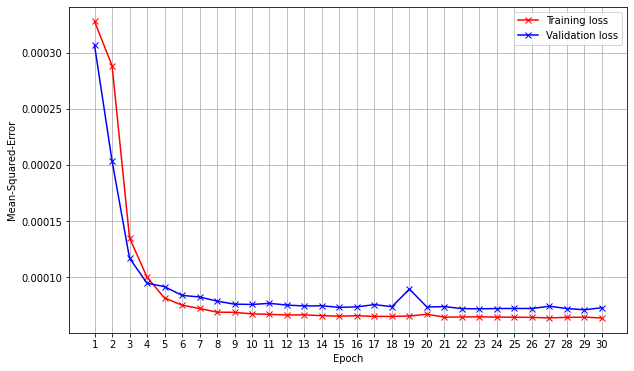

In [ ]:
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

x = [i + 1 for i in range(30)]
plt.plot(x, history.history["loss"], label="Training loss", color='red', marker='x')
plt.plot(x, history.history["val_loss"], label="Validation loss", color='blue', marker='x')
plt.xticks(x)
#plt.ylim([0, max(*history.history["loss"], *history.history["val_loss"])])
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean-Squared-Error")
plt.legend()
plt.savefig('results_loss.pdf', dpi=120, format='pdf', bbox_inches='tight')
